<a href="https://colab.research.google.com/github/bekku/deeplearning/blob/master/Resnet18%E3%81%8B%E3%82%89%E3%81%AE%E8%92%B8%E7%95%99%E5%AE%9F%E9%A8%93(%E6%B8%A9%E5%BA%A6%E3%81%AB%E3%82%88%E3%82%8B%E7%B2%BE%E5%BA%A6%E7%A2%BA%E8%AA%8D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time

!pip install deap

from google.colab import drive #インポート
drive.mount('/content/gdrive') #GoogleDriveのマウント
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
    )

    return {'train': train_loader, 'test': test_loader}

torch.cuda.is_available()

     |████████████████████████████████| 163kB 4.6MB/s 
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


True

# 教師モデルの定義(resnet18)

In [ ]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

## 教師モデルの学習

In [ ]:
if __name__ == '__main__':
    epoch = 70

    loader = load_cifar10()


    net: ResNet18 = ResNet18()
    param = torch.load('/content/gdrive/My Drive/研究コード/resnet18_model_weight_3.pth')
    net.load_state_dict(param)
    criterion = torch.nn.CrossEntropyLoss()  # ロスの計算
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.1, momentum=0.9)
    
    # もしGPUが使えるなら使う
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)


    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    for e in range(epoch):
        
        ################################### 学習 #################################
        
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device)  # to GPU?
            labels = labels.to(device)
            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            if i % 90 == 0:
                print('Training log: {} epoch ({} / 50000 train. data). Loss: {}'.format(e + 1,
                                                                                         (i + 1) * 128,
                                                                                         loss.item())
                      )


        history['train_loss'].append(loss.item())

        
        
        ################################### 推論 #################################
        
        
        net.eval()
        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['train']):
                images = images.to(device)  # to GPU?
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 50000)
        print(acc)
        history['train_acc'].append(acc)

        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['test']):
                images = images.to(device)  # to GPU?
                labels = labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 10000)
        print(acc)
        history['test_acc'].append(acc)
        
    #====== 保存 =======
    torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/resnet18_model_weight_4.pth')

    # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history['train_acc'], label='train_acc')
    plt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')

Files already downloaded and verified
Files already downloaded and verified
Training log: 1 epoch (128 / 50000 train. data). Loss: 7.659196853637695e-06
Training log: 1 epoch (11648 / 50000 train. data). Loss: 2.5779008865356445e-06
Training log: 1 epoch (23168 / 50000 train. data). Loss: 4.947185516357422e-06
Training log: 1 epoch (34688 / 50000 train. data). Loss: 1.7881393432617188e-06
Training log: 1 epoch (46208 / 50000 train. data). Loss: 3.1739473342895508e-06
1.0
0.8214
Training log: 2 epoch (128 / 50000 train. data). Loss: 8.03917646408081e-06
Training log: 2 epoch (11648 / 50000 train. data). Loss: 4.349648952484131e-05
Training log: 2 epoch (23168 / 50000 train. data). Loss: 0.00021094083786010742
Training log: 2 epoch (34688 / 50000 train. data). Loss: 5.163252353668213e-06
Training log: 2 epoch (46208 / 50000 train. data). Loss: 8.448958396911621e-06
1.0
0.8229
Training log: 3 epoch (128 / 50000 train. data). Loss: 1.0505318641662598e-06
Training log: 3 epoch (11648 / 5000

KeyboardInterrupt: ignored

教師モデルに温度付きソフトマックス関数を追加、温度クロスエントロピーも実装

In [ ]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x,T):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = out/T ##追加
        return f.softmax(out) ##追加


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

# 教師モデルと生徒モデルのcross_entropyの損失関数の定義
class T_S_Closs_entropy(torch.nn.Module):
    def __init__(self):
        super(T_S_Closs_entropy, self).__init__()

    def forward(self, p, q):
        #pが教師モデル、qが生徒モデルの出力値(既に対数化してます)。
        loss = p*q
        loss = torch.sum(loss)
        loss*=-1
        return loss

# **教師モデルの設定(s_max,a_max)**

In [ ]:
Tnet: ResNet18 = ResNet18()
param = torch.load('/content/gdrive/My Drive/研究コード/resnet18_model_weight_3.pth')
Tnet.load_state_dict(param)
loader = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet.to(device)
s_max=0
for i in range(10):
    t1 = time.time()
    correct = 0
    with torch.no_grad():
        for images, labels in loader['test']:
            images = images.to(device) 
            labels = labels.to(device)
            outputs = Tnet(images,1)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    t2 = time.time()
    s_max += t2-t1
a_max = float(correct / 10000)
print(a_max)
t2 = time.time()
s_max /= 10
print(f"経過時間：{s_max}")

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.8211
経過時間：3.3498772859573362


# **❌教師モデルの出力をリスト化**(GA時の計算量削減のため)

In [ ]:
# 学習データの出力(教師出力)をリストとしてメモ化
max_model_outputs_list = []
print("出力")
epoch = 50
temp = 20
for e in range(epoch):
    with torch.no_grad():
        for i,images, labels in enumerate(loader['train']):
            images = images.to(device)  # to GPU?
            max_model_outputs_list.append([images,Tnet(images,temp)])
    if e%10==0:
      print("epoch:{}".format(e))

# **温度付きNNモデル生成関数**

In [ ]:
class CreateNet(torch.nn.Module):
    def __init__(self, NN_model_list):
        super(CreateNet, self).__init__()

        self.NN_model_list_2=[]
        for i in range(len(NN_model_list)):
            if NN_model_list[i]!=0:
                self.NN_model_list_2.append(NN_model_list[i])

        NN_model_list=[len(self.NN_model_list_2)]+self.NN_model_list_2

        # 隠れ層0の時エラー処理用 if。
        if NN_model_list[0] > 0:
            for i in range(len(NN_model_list)-1):
                if i==0:
                   self._modules["fc"+str(i+1)]= torch.nn.Linear(3 * 32 * 32, NN_model_list[1])
                   #入力層
                else:
                    self._modules["fc"+str(i+1)]= torch.nn.Linear(NN_model_list[i], NN_model_list[i+1])
                   #出力層 fcリストの個数は、常にNN_model_list[0]+1である。
            self._modules["fc"+str(i+2)]= torch.nn.Linear(NN_model_list[-1], 10)

        else:
            self._modules["fc"+str(1)]= torch.nn.Linear(3 * 32 * 32, 10)

    def forward(self, x, T):
        for i in range(len(self._modules)-1):
            x = f.relu(self._modules["fc"+str(i+1)](x))
        x = self._modules["fc"+str(len(self._modules))](x)
        x = x/T
        return f.log_softmax(x)

# **速度と精度の評価関数(最大化予定)**

In [ ]:
def speed_acc_normalization(spe_max,spe_min,spe,acc_max,acc_min,acc):
    if spe_min<=spe<=spe_max:
        speed_normalization = ((spe_max-spe+1) - spe_min) / ( (spe_max - spe_min) * 2 )
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = (acc - acc_min) / ( (acc_max - acc_min) * 2 )
    else:
        accuracy_normalization=0
    print("----------------")
    print("速度:{} ,精度:{}".format(spe,acc))
    print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    print("評価指標:{}".format(speed_normalization + accuracy_normalization))
    print("----------------")

    return speed_normalization + accuracy_normalization

# **評価関数 evaluater(数値と精度の評価値出力) の定義**



In [ ]:
loaders = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet: ResNet18 = ResNet18()
param = torch.load('/content/gdrive/My Drive/研究コード/resnet18_model_weight_3.pth')
Tnet.load_state_dict(param)
Tnet.to(device)
criterion = T_S_Closs_entropy()

#　遺伝的評価関数、引数 : gane=層ごとの2の条数-リスト、temp = 温度、スピード最大、精度最大。
def evaluater(gane):
    # 入力された乗数から、本当のモデルのノード数とする。
    model_gane=[]
    for i in gane:
      if i==0:
          model_gane.append(0)
      else:
          model_gane.append(2**i)

    #温度設定
    temp=20

    # 学習回数
    epoch = 10
    net: torch.nn.Module = CreateNet(model_gane)
    net.to(device)

    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.1)

    for e in range(1,epoch+1):
        """　学習　開始"""
        loss = None
        net.train()
        for data, target in loaders['train']:
            data = data.to(device)
            target = target.to(device)

            max_model_outputs = Tnet(data,temp)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,temp)

            optimizer.zero_grad()
            loss = criterion(max_model_outputs,output)

            loss.backward()
            optimizer.step()
        if e%10==0:
            print('temp: {} ,Training log: {} ,Loss: {}'.format(temp,e,loss.item()))

        # for data in max_model_outputs_list:
        #     images = data[0].to(device)
        #     max_model_outputs = data[1]#メモ化していることで計算しない。
        #     output = net(images,temp)

        #     optimizer.zero_grad()
        #     loss = criterion(max_model_outputs,output)

        #     loss.backward()
        #     optimizer.step()

        if e%10==0:
            print('temp: {} ,Training log: {} ,Loss: {}'.format(temp,e,loss.item()))

    """  学習したモデルの速度と精度の評価をする。(推論)"""
    net.eval()
    correct = 0
    t1 = time.time()
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.to(device) 
            labels = labels.to(device)
            data = images.view(-1, 32 * 32 * 3)
            #　蒸留モデルは、推論時は温度を1に戻します。
            outputs = net(data,1)
            _, predicted = torch.max(outputs.data, 1)
            #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
            correct += (predicted == labels).sum().item()

    acc = float(correct / 10000)
    t2 = time.time()
    elapsed_time = t2-t1

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    return (speed_acc_normalization(s_max,0,elapsed_time,a_max,0,acc),)
print("出力")

Files already downloaded and verified
Files already downloaded and verified
出力


# **GAによる、モデル探索(evaluaterの最大化)**



In [ ]:
import random
from deap import base, creator, tools


# 適応度クラスの作成
# 最大化したい場合1.0
# 最小化したい場合-1.0
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# 個体クラスの作成
creator.create("Individual", list, fitness=creator.FitnessMax)

# Toolboxの作成
toolbox = base.Toolbox()

# 遺伝子を生成する関数"attr_gene"を登録
# 0~14の値をランダムに生成する。
toolbox.register("attr_gene", random.randrange, 0, 14)

# 個体を生成する関数”individual"を登録
# initRepeat(creator.Individual,遺伝子生成関数, N)
# N回遺伝子生成関数を実行し、creator.Individualに格納して返す関数
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_gene, 5)

# 世代(個体集団)を生成する関数"population"を登録
# 個体生成したものを集めて、世代化
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 評価関数"evaluate"を登録
toolbox.register("evaluate", evaluater)

# 交叉を行う関数"mate"を登録
toolbox.register("mate", tools.cxTwoPoint)

# 変異を行う関数"mutate"を登録
toolbox.register("mutate", tools.mutUniformInt, low=0, up=14, indpb=0.2)

# 個体選択法"select"を登録
toolbox.register("select", tools.selTournament, tournsize=3)


def main():

    random.seed()

    # GAパラメータ
    N_GEN = 30      # 繰り返し世代数
    POP_SIZE = 20   # 集団内の個体数
    CX_PB = 0.5     # 交叉確率
    MUT_PB = 0.05    # 変異確率0.05

    # 個体集団の生成
    pop = toolbox.population(n=POP_SIZE)
    print("遺伝的探索開始")
    print(pop)

    # 個体集団の適応度の評価
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    print("  Evaluated %i individuals" % len(pop))
    # 適応度の抽出
    fits = [ind.fitness.values[0] for ind in pop]

    print("-----------------------")
    # 進化ループ開始
    g = 0
    while g < N_GEN:

        g = g + 1
        print("-- Generation %i --" % g)

        # 次世代個体の選択・複製
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        print(offspring)

        # 交叉
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # 交叉させる個体を選択
            if random.random() < CX_PB:
                toolbox.mate(child1, child2)

                # 交叉させた個体は適応度を削除する
                del child1.fitness.values
                del child2.fitness.values

        # 変異
        for mutant in offspring:

            # 変異させる個体を選択
            if random.random() < MUT_PB:
                print("変異前:{}".format(mutant))
                toolbox.mutate(mutant)
                print("変異後:{}".format(mutant))

                # 変異させた個体は適応度を削除する
                del mutant.fitness.values


        # 適応度を削除した個体について適応度の再評価を行う
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        print(invalid_ind)
        fitnesses = map(toolbox.evaluate, invalid_ind)

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        print("  Evaluated %i individuals" % len(invalid_ind))

        # 個体集団を新世代個体集団で更新
        pop[:] = offspring

        # 新世代の全個体の適応度の抽出
        fits = [ind.fitness.values[0] for ind in pop]

        # 適応度の統計情報の出力
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5

        print("  Min %s" % min(fits))
        print("  Max %s" % max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)


    print("-- End of (successful) evolution --")

    # 最良個体の抽出
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))


if __name__ == '__main__':

    main()

KeyboardInterrupt: ignored

確認用evaluater　主にGAの出したものを確認するもの。

In [ ]:
def evaluater(gane):
    # 入力された乗数から、本当のモデルのノード数とする。
    model_gane=[]
    for i in gane:
      if i==0:
          model_gane.append(0)
      else:
          model_gane.append(2**i)

    #温度設定
    temp=10

    # 学習回数
    epoch = 50
    net: torch.nn.Module = CreateNet(model_gane)
    net.to(device)

    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

    for e in range(1,epoch+1):
        """　学習　開始"""
        loss = None
        net.train()
        for data, target in loaders['train']:
                
            data = data.to(device)
            target = target.to(device)

            max_model_outputs = Tnet(data,temp)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,temp)

            optimizer.zero_grad()
            loss = criterion(max_model_outputs,output)

            loss.backward()
            optimizer.step()
        if e%10==0:
            print('temp: {} ,Training log: {} ,Loss: {}'.format(temp,e,loss.item()))

    #torch.save(net.state_dict(), 'GA_student_NN_12_8_11_3_6_11.pth')

    """  学習したモデルの速度と精度の評価をする。(推論)"""
    net.eval()
    elapsed_time=0
    for i in range(10):
        correct = 0
        t1 = time.time()
        with torch.no_grad():
            for images, labels in loaders['test']:
                images = images.to(device) 
                labels = labels.to(device)
                data = images.view(-1, 32 * 32 * 3)
                #　蒸留モデルは、推論時は温度を1に戻します。
                outputs = net(data,1)
                _, predicted = torch.max(outputs.data, 1)
                #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
                correct += (predicted == labels).sum().item()

        acc = float(correct / 10000)
        t2 = time.time()
        elapsed_time += t2-t1
    elapsed_time /=10

    # accとelapsedは、教師モデルの出力を受け取るようにしておきましょう。
    return speed_acc_normalization(s_max,0,elapsed_time,a_max,0,acc)
print("---確認用evaluater関数---")

温度付き蒸留が正常に動くか・実行時間の確認



Adamの学習率0.1の温度1000→ある良い精度に達して落ちる。

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 1000 ,epoch：Loss: 10
0.4929
temp: 1000 ,epoch：Loss: 20
0.1295
temp: 1000 ,epoch：Loss: 30
0.2183
temp: 1000 ,epoch：Loss: 40
0.1209
temp: 1000 ,epoch：Loss: 50
0.14
1421.566678762436


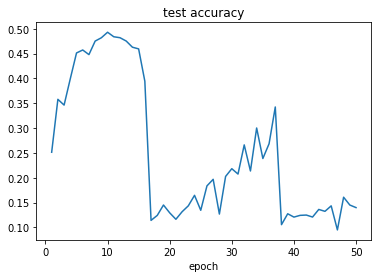

In [ ]:

epoch = 50
temp = 1000
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    if e%10==0:
        print('temp: {} ,epoch{}：Loss: {}'.format(temp,e ,loss.item()))
        acc = float(correct / 10000)
        print(acc)
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Adamの学習率0.1の温度10000→温度1000と同様、ある良い精度に達して落ちる。

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 10000 ,epoch : 1 ,Loss: 184.20681762695312
accuracy:0.3139
temp: 10000 ,epoch : 2 ,Loss: 184.20681762695312
accuracy:0.358
temp: 10000 ,epoch : 3 ,Loss: 184.206787109375
accuracy:0.4228
temp: 10000 ,epoch : 4 ,Loss: 184.206787109375
accuracy:0.3379
temp: 10000 ,epoch : 5 ,Loss: 184.206787109375
accuracy:0.4682
temp: 10000 ,epoch : 6 ,Loss: 184.206787109375
accuracy:0.4674
temp: 10000 ,epoch : 7 ,Loss: 184.206787109375
accuracy:0.48
temp: 10000 ,epoch : 8 ,Loss: 184.206787109375
accuracy:0.4672
temp: 10000 ,epoch : 9 ,Loss: 184.206787109375
accuracy:0.485
temp: 10000 ,epoch : 10 ,Loss: 184.206787109375
accuracy:0.4855
temp: 10000 ,epoch : 11 ,Loss: 184.20677185058594
accuracy:0.4748
temp: 10000 ,epoch : 12 ,Loss: 184.20677185058594
accuracy:0.5033
temp: 10000 ,epoch : 13 ,Loss: 184.206787109375
accuracy:0.4899
temp: 10000 ,epoch : 14 ,Loss: 184.206787109375
accuracy:0.4839
temp: 10000 ,epoch : 15 ,Loss: 184.206787109375
accuracy:0.4555
temp: 10000 ,epoch : 16 ,Loss: 184.2067871093

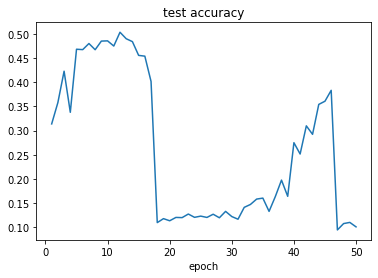

In [ ]:
epoch = 50
temp = 10000
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Adamの学習率0.1の温度100000→なんかうまくいっている？？？？

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 100000 ,epoch : 1 ,Loss: 184.20681762695312
accuracy:0.4673
temp: 100000 ,epoch : 2 ,Loss: 184.20680236816406
accuracy:0.4749
temp: 100000 ,epoch : 3 ,Loss: 184.20680236816406
accuracy:0.4745
temp: 100000 ,epoch : 4 ,Loss: 184.20681762695312
accuracy:0.4959
temp: 100000 ,epoch : 5 ,Loss: 184.20681762695312
accuracy:0.5101
temp: 100000 ,epoch : 6 ,Loss: 184.20680236816406
accuracy:0.5191
temp: 100000 ,epoch : 7 ,Loss: 184.20681762695312
accuracy:0.5228
temp: 100000 ,epoch : 8 ,Loss: 184.20681762695312
accuracy:0.5265
temp: 100000 ,epoch : 9 ,Loss: 184.20681762695312
accuracy:0.5198
temp: 100000 ,epoch : 10 ,Loss: 184.20681762695312
accuracy:0.5235
temp: 100000 ,epoch : 11 ,Loss: 184.20680236816406
accuracy:0.5312
temp: 100000 ,epoch : 12 ,Loss: 184.20680236816406
accuracy:0.536
temp: 100000 ,epoch : 13 ,Loss: 184.20681762695312
accuracy:0.5354
temp: 100000 ,epoch : 14 ,Loss: 184.20681762695312
accuracy:0.5324
temp: 100000 ,epoch : 15 ,Loss: 184.20681762695312
accuracy:0.5388
temp:

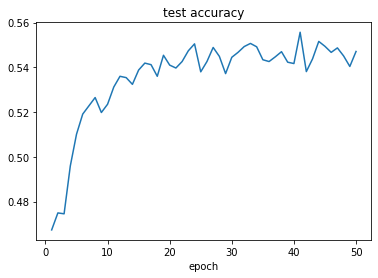

In [ ]:
epoch = 50
temp = 100000
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Adamの学習率0.1の温度10→クソ

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 10 ,epoch : 1 ,Loss: 2220.783203125
accuracy:0.1889
temp: 10 ,epoch : 2 ,Loss: 1443.30322265625
accuracy:0.2086
temp: 10 ,epoch : 3 ,Loss: 1492.958740234375
accuracy:0.2097
temp: 10 ,epoch : 4 ,Loss: 1798.9581298828125
accuracy:0.2441
temp: 10 ,epoch : 5 ,Loss: 2409.22998046875
accuracy:0.1917
temp: 10 ,epoch : 6 ,Loss: 1855.216796875
accuracy:0.2126
temp: 10 ,epoch : 7 ,Loss: 905.3424682617188
accuracy:0.2203
temp: 10 ,epoch : 8 ,Loss: 978.0238037109375
accuracy:0.2193
temp: 10 ,epoch : 9 ,Loss: 4179.37451171875
accuracy:0.2264
temp: 10 ,epoch : 10 ,Loss: 2065.794189453125
accuracy:0.2359
temp: 10 ,epoch : 11 ,Loss: 308.1719970703125
accuracy:0.2593
temp: 10 ,epoch : 12 ,Loss: 196.9888153076172
accuracy:0.2663
temp: 10 ,epoch : 13 ,Loss: 235.4521942138672
accuracy:0.2847
temp: 10 ,epoch : 14 ,Loss: 38069.9765625
accuracy:0.1983
temp: 10 ,epoch : 15 ,Loss: 1148.2147216796875
accuracy:0.1803
temp: 10 ,epoch : 16 ,Loss: 281.1474914550781
accuracy:0.1831
temp: 10 ,epoch : 17 ,Loss: 

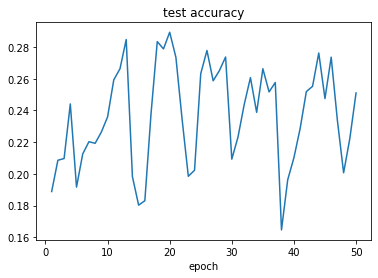

In [ ]:
epoch = 50
temp = 10
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Adamの学習率0.001の温度10

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 10 ,epoch : 1 ,Loss: 143.56100463867188
accuracy:0.4819
temp: 10 ,epoch : 2 ,Loss: 147.3884735107422
accuracy:0.5043
temp: 10 ,epoch : 3 ,Loss: 140.17218017578125
accuracy:0.5244
temp: 10 ,epoch : 4 ,Loss: 134.47128295898438
accuracy:0.5387
temp: 10 ,epoch : 5 ,Loss: 131.87059020996094
accuracy:0.5351
temp: 10 ,epoch : 6 ,Loss: 123.54193115234375
accuracy:0.5415
temp: 10 ,epoch : 7 ,Loss: 131.09474182128906
accuracy:0.5414
temp: 10 ,epoch : 8 ,Loss: 128.35549926757812
accuracy:0.5438
temp: 10 ,epoch : 9 ,Loss: 126.69693756103516
accuracy:0.56
temp: 10 ,epoch : 10 ,Loss: 133.273681640625
accuracy:0.5555
temp: 10 ,epoch : 11 ,Loss: 120.84716796875
accuracy:0.55
temp: 10 ,epoch : 12 ,Loss: 125.30812072753906
accuracy:0.5549
temp: 10 ,epoch : 13 ,Loss: 129.377197265625
accuracy:0.545
temp: 10 ,epoch : 14 ,Loss: 123.78860473632812
accuracy:0.5519
temp: 10 ,epoch : 15 ,Loss: 122.79597473144531
accuracy:0.5449
temp: 10 ,epoch : 16 ,Loss: 116.42018127441406
accuracy:0.556
temp: 10 ,epoch

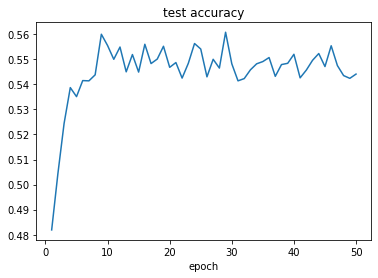

In [ ]:
epoch = 50
temp = 10
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Adamの学習率0.001の温度1000

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 1000 ,epoch : 1 ,Loss: 184.20411682128906
accuracy:0.4744
temp: 1000 ,epoch : 2 ,Loss: 184.20443725585938
accuracy:0.5008
temp: 1000 ,epoch : 3 ,Loss: 184.20362854003906
accuracy:0.5119
temp: 1000 ,epoch : 4 ,Loss: 184.2037353515625
accuracy:0.5241
temp: 1000 ,epoch : 5 ,Loss: 184.20376586914062
accuracy:0.5383
temp: 1000 ,epoch : 6 ,Loss: 184.20396423339844
accuracy:0.5388
temp: 1000 ,epoch : 7 ,Loss: 184.20347595214844
accuracy:0.5367
temp: 1000 ,epoch : 8 ,Loss: 184.2029266357422
accuracy:0.5467
temp: 1000 ,epoch : 9 ,Loss: 184.20343017578125
accuracy:0.5495
temp: 1000 ,epoch : 10 ,Loss: 184.20294189453125
accuracy:0.5448
temp: 1000 ,epoch : 11 ,Loss: 184.20281982421875
accuracy:0.5482
temp: 1000 ,epoch : 12 ,Loss: 184.20286560058594
accuracy:0.5477
temp: 1000 ,epoch : 13 ,Loss: 184.20278930664062
accuracy:0.5513
temp: 1000 ,epoch : 14 ,Loss: 184.20278930664062
accuracy:0.5594
temp: 1000 ,epoch : 15 ,Loss: 184.2028350830078
accuracy:0.5573
temp: 1000 ,epoch : 16 ,Loss: 184.203

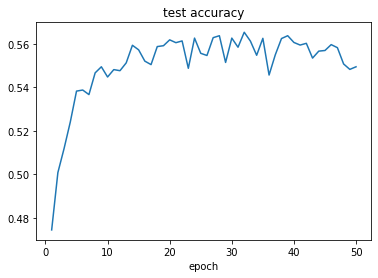

In [ ]:
epoch = 50
temp = 1000
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Adamの学習率0.001の温度10000

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 10000 ,epoch : 1 ,Loss: 184.20677185058594
accuracy:0.4482
temp: 10000 ,epoch : 2 ,Loss: 184.20677185058594
accuracy:0.4944
temp: 10000 ,epoch : 3 ,Loss: 184.206787109375
accuracy:0.5057
temp: 10000 ,epoch : 4 ,Loss: 184.20677185058594
accuracy:0.5253
temp: 10000 ,epoch : 5 ,Loss: 184.206787109375
accuracy:0.5203
temp: 10000 ,epoch : 6 ,Loss: 184.20677185058594
accuracy:0.5322
temp: 10000 ,epoch : 7 ,Loss: 184.206787109375
accuracy:0.5324
temp: 10000 ,epoch : 8 ,Loss: 184.20677185058594
accuracy:0.5377
temp: 10000 ,epoch : 9 ,Loss: 184.206787109375
accuracy:0.541
temp: 10000 ,epoch : 10 ,Loss: 184.206787109375
accuracy:0.5496
temp: 10000 ,epoch : 11 ,Loss: 184.20677185058594
accuracy:0.556
temp: 10000 ,epoch : 12 ,Loss: 184.20677185058594
accuracy:0.5534
temp: 10000 ,epoch : 13 ,Loss: 184.20677185058594
accuracy:0.5591
temp: 10000 ,epoch : 14 ,Loss: 184.20675659179688
accuracy:0.5473
temp: 10000 ,epoch : 15 ,Loss: 184.20677185058594
accuracy:0.5525
temp: 10000 ,epoch : 16 ,Loss: 

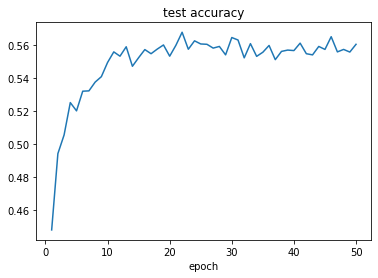

In [ ]:
epoch = 50
temp = 10000
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Adamの学習率0.001の温度100000 → **温度を高くすればするほど、収束までepochが必要**


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 100000 ,epoch : 1 ,Loss: 184.20680236816406
accuracy:0.2973
temp: 100000 ,epoch : 2 ,Loss: 184.20681762695312
accuracy:0.3291
temp: 100000 ,epoch : 3 ,Loss: 184.20680236816406
accuracy:0.357
temp: 100000 ,epoch : 4 ,Loss: 184.20680236816406
accuracy:0.3749
temp: 100000 ,epoch : 5 ,Loss: 184.20681762695312
accuracy:0.3892
temp: 100000 ,epoch : 6 ,Loss: 184.20680236816406
accuracy:0.4023
temp: 100000 ,epoch : 7 ,Loss: 184.20681762695312
accuracy:0.411
temp: 100000 ,epoch : 8 ,Loss: 184.20681762695312
accuracy:0.4183
temp: 100000 ,epoch : 9 ,Loss: 184.20681762695312
accuracy:0.4237
temp: 100000 ,epoch : 10 ,Loss: 184.20680236816406
accuracy:0.4287
temp: 100000 ,epoch : 11 ,Loss: 184.20680236816406
accuracy:0.434
temp: 100000 ,epoch : 12 ,Loss: 184.20680236816406
accuracy:0.4383
temp: 100000 ,epoch : 13 ,Loss: 184.20680236816406
accuracy:0.4426
temp: 100000 ,epoch : 14 ,Loss: 184.20681762695312
accuracy:0.4464
temp: 100000 ,epoch : 15 ,Loss: 184.20681762695312
accuracy:0.4532
temp: 1

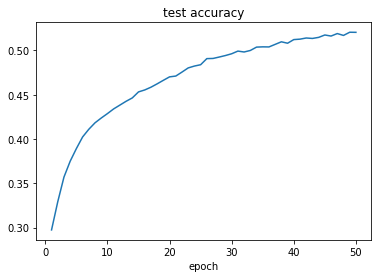

In [ ]:
epoch = 50
temp = 100000
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Adamの学習率0.001の温度50000

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 50000 ,epoch : 1 ,Loss: 184.20681762695312
accuracy:0.366
temp: 50000 ,epoch : 2 ,Loss: 184.20681762695312
accuracy:0.4127
temp: 50000 ,epoch : 3 ,Loss: 184.20681762695312
accuracy:0.4309
temp: 50000 ,epoch : 4 ,Loss: 184.20680236816406
accuracy:0.45
temp: 50000 ,epoch : 5 ,Loss: 184.20681762695312
accuracy:0.4603
temp: 50000 ,epoch : 6 ,Loss: 184.20680236816406
accuracy:0.4706
temp: 50000 ,epoch : 7 ,Loss: 184.20681762695312
accuracy:0.4842
temp: 50000 ,epoch : 8 ,Loss: 184.20680236816406
accuracy:0.4889
temp: 50000 ,epoch : 9 ,Loss: 184.20680236816406
accuracy:0.4955
temp: 50000 ,epoch : 10 ,Loss: 184.20680236816406
accuracy:0.5006
temp: 50000 ,epoch : 11 ,Loss: 184.20680236816406
accuracy:0.5093
temp: 50000 ,epoch : 12 ,Loss: 184.20681762695312
accuracy:0.511
temp: 50000 ,epoch : 13 ,Loss: 184.20681762695312
accuracy:0.5201
temp: 50000 ,epoch : 14 ,Loss: 184.20681762695312
accuracy:0.5179
temp: 50000 ,epoch : 15 ,Loss: 184.20681762695312
accuracy:0.5228
temp: 50000 ,epoch : 16

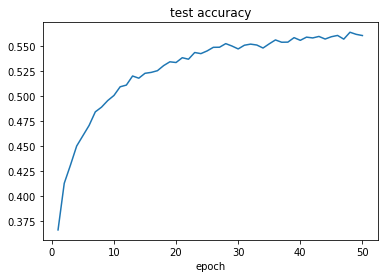

In [ ]:
epoch = 50
temp = 50000
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Adamの学習率0.001の温度5

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 5 ,epoch : 1 ,Loss: 123.72431945800781
accuracy:0.4791
temp: 5 ,epoch : 2 ,Loss: 111.30429077148438
accuracy:0.4968
temp: 5 ,epoch : 3 ,Loss: 127.6292495727539
accuracy:0.5098
temp: 5 ,epoch : 4 ,Loss: 100.59203338623047
accuracy:0.5153
temp: 5 ,epoch : 5 ,Loss: 92.08221435546875
accuracy:0.5227
temp: 5 ,epoch : 6 ,Loss: 112.96817779541016
accuracy:0.5183
temp: 5 ,epoch : 7 ,Loss: 102.13152313232422
accuracy:0.5284
temp: 5 ,epoch : 8 ,Loss: 88.97367858886719
accuracy:0.5388
temp: 5 ,epoch : 9 ,Loss: 82.77874755859375
accuracy:0.5414
temp: 5 ,epoch : 10 ,Loss: 78.89374542236328
accuracy:0.5354
temp: 5 ,epoch : 11 ,Loss: 87.02780151367188
accuracy:0.5436
temp: 5 ,epoch : 12 ,Loss: 67.31468200683594
accuracy:0.5486
temp: 5 ,epoch : 13 ,Loss: 83.68014526367188
accuracy:0.5414
temp: 5 ,epoch : 14 ,Loss: 73.96697235107422
accuracy:0.5389
temp: 5 ,epoch : 15 ,Loss: 79.84211730957031
accuracy:0.5418
temp: 5 ,epoch : 16 ,Loss: 66.57150268554688
accuracy:0.5427
temp: 5 ,epoch : 17 ,Loss: 6

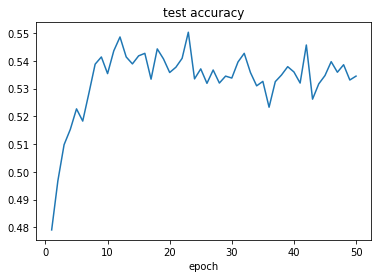

In [ ]:
epoch = 50
temp = 5
net: torch.nn.Module = CreateNet([1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 5 ,epoch : 1 ,Loss: 136.38226318359375
accuracy:0.4614
temp: 5 ,epoch : 2 ,Loss: 116.74183654785156
accuracy:0.4933
temp: 5 ,epoch : 3 ,Loss: 114.0146484375
accuracy:0.526
temp: 5 ,epoch : 4 ,Loss: 104.735595703125
accuracy:0.5361
temp: 5 ,epoch : 5 ,Loss: 101.5325927734375
accuracy:0.5432
temp: 5 ,epoch : 6 ,Loss: 98.28559875488281
accuracy:0.556
temp: 5 ,epoch : 7 ,Loss: 91.32527923583984
accuracy:0.5435
temp: 5 ,epoch : 8 ,Loss: 65.16595458984375
accuracy:0.5549
temp: 5 ,epoch : 9 ,Loss: 67.29322052001953
accuracy:0.5577
temp: 5 ,epoch : 10 ,Loss: 64.1950454711914
accuracy:0.5576
temp: 5 ,epoch : 11 ,Loss: 65.08329010009766
accuracy:0.5599
temp: 5 ,epoch : 12 ,Loss: 48.404991149902344
accuracy:0.5659
temp: 5 ,epoch : 13 ,Loss: 41.42671585083008
accuracy:0.565
temp: 5 ,epoch : 14 ,Loss: 40.99800109863281
accuracy:0.5654
temp: 5 ,epoch : 15 ,Loss: 40.42040252685547
accuracy:0.5656
temp: 5 ,epoch : 16 ,Loss: 36.49359130859375
accuracy:0.5686
temp: 5 ,epoch : 17 ,Loss: 46.57391357

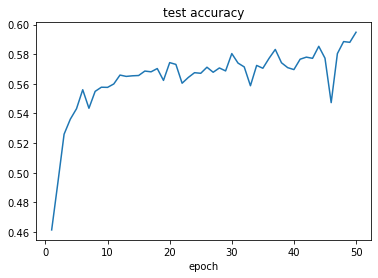

In [39]:
epoch = 50
temp = 5
net: torch.nn.Module = CreateNet([1024,1024,1024])
loaders = load_cifar10()
criterion = T_S_Closs_entropy()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
Tnet.to(device)

history = {
    'train_loss': [],
    'test_loss': [],
    'test_acc': [],
    }
t_kaisi = time.time()
for e in range(1,epoch+1):
    """ Training Part"""
    loss = None
    net.train()
    for data, target in loaders['train']:
                
        data = data.to(device)
        target = target.to(device)

        max_model_outputs = Tnet(data,temp)
        data = data.view(-1, 32 * 32 * 3)
        output = net(data,temp)

        optimizer.zero_grad()

        loss = criterion(max_model_outputs,output)

        loss.backward()
        optimizer.step()


    net.eval()
    correct = 0
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device) 
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,1)
            test_loss += f.nll_loss(f.log_softmax(output, dim=1), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    history['test_acc'].append(correct / 10000)

    
    print('temp: {} ,epoch : {} ,Loss: {}'.format(temp,e ,loss.item()))
    acc = float(correct / 10000)
    print("accuracy:{}".format(acc))
t_owari = time.time()
print(t_owari-t_kaisi)
#====== 保存 =======
# torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/NN_model_weight_1.pth') # 保存
plt.figure()
plt.plot(range(1, epoch+1), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('test_acc.png')

1024,1024,1024通常学習

Files already downloaded and verified
Files already downloaded and verified
CreateNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=10, bias=True)
)
Training log: 1 epoch (128 / 50000 train. data). Loss: 2.302276849746704


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Training log: 1 epoch (11648 / 50000 train. data). Loss: 1.6674840450286865
Training log: 1 epoch (23168 / 50000 train. data). Loss: 1.5287634134292603
Training log: 1 epoch (34688 / 50000 train. data). Loss: 1.6043671369552612
Training log: 1 epoch (46208 / 50000 train. data). Loss: 1.4616285562515259
0.47492
0.4651
Training log: 2 epoch (128 / 50000 train. data). Loss: 1.596625566482544
Training log: 2 epoch (11648 / 50000 train. data). Loss: 1.4270232915878296
Training log: 2 epoch (23168 / 50000 train. data). Loss: 1.437468409538269
Training log: 2 epoch (34688 / 50000 train. data). Loss: 1.3242180347442627
Training log: 2 epoch (46208 / 50000 train. data). Loss: 1.321887731552124
0.52326
0.489
Training log: 3 epoch (128 / 50000 train. data). Loss: 1.3286563158035278
Training log: 3 epoch (11648 / 50000 train. data). Loss: 1.3430894613265991
Training log: 3 epoch (23168 / 50000 train. data). Loss: 1.2718017101287842
Training log: 3 epoch (34688 / 50000 train. data). Loss: 1.2305798

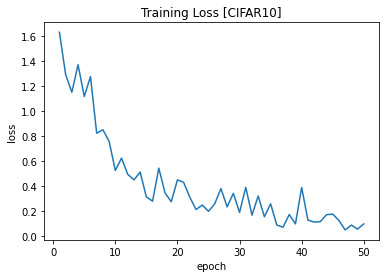

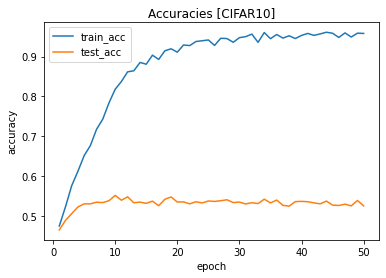

In [49]:
if __name__ == '__main__':
    epoch = 50

    loader = load_cifar10()


    net: torch.nn.Module = CreateNet([1024,1024,1024])
    print(CreateNet([1024,1024,1024]))
    criterion = torch.nn.CrossEntropyLoss()  # ロスの計算
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    
    # もしGPUが使えるなら使う
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)


    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    for e in range(epoch):
        
        ################################### 学習 #################################
        
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            images = images.to(device)  # to GPU?
            labels = labels.to(device)
            optimizer.zero_grad()
            images = images.view(-1, 32 * 32 * 3)
            output = net(images,1)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            if i % 90 == 0:
                print('Training log: {} epoch ({} / 50000 train. data). Loss: {}'.format(e + 1,
                                                                                         (i + 1) * 128,
                                                                                         loss.item())
                      )


        history['train_loss'].append(loss.item())

        
        
        ################################### 推論 #################################
        
        
        net.eval()
        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['train']):
                images = images.to(device)  # to GPU?
                labels = labels.to(device)
                images = images.view(-1, 32 * 32 * 3)
                outputs = net(images,1)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 50000)
        print(acc)
        history['train_acc'].append(acc)

        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(loader['test']):
                images = images.to(device)  # to GPU?
                labels = labels.to(device)
                images = images.view(-1, 32 * 32 * 3)
                outputs = net(images,1)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 10000)
        print(acc)
        history['test_acc'].append(acc)
        
    #====== 保存 =======
    # torch.save(net.state_dict(), '/content/gdrive/My Drive/研究コード/resnet18_model_weight_4.pth')

    # 結果をプロット
    plt.figure()
    plt.plot(range(1, epoch+1), history['train_loss'])
    plt.title('Training Loss [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('cifar10_loss.png')
    
    
    plt.figure()
    plt.plot(range(1, epoch + 1), history['train_acc'], label='train_acc')
    plt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')
    plt.title('Accuracies [CIFAR10]')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig('cifar10_acc.png')